**Resources**

https://huggingface.co/collections/ustc-community/d-fine-68109b427cbe6ee36b4e7352

In [1]:
!nvidia-smi

Sat May 10 20:14:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             29W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install uv

# Latests transformers + vision libraries
!pip install -q -U git+https://github.com/VladOS95-cyber/transformers@add-dfine-model
!pip install -q -U timm torchvision Pillow numpy==1.*

# For training
!pip install -q -U supervision
!pip install -q -U datasets accelerate
!pip install -q -U "albumentations==1.4.6" torchmetrics

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 102.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.2 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 66.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 8.4 MB/s eta 0:00:000:0

In [3]:
checkpoint = "ustc-community/dfine-nano-coco"
image_size = 480

In [4]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()
import random
import cv2
import os
import albumentations as A
from sklearn.model_selection import train_test_split

**Downloading the Kaggle Dataset**

In [5]:
cocoa_dataset = "/kaggle/input/amini-cocoa-contamination-dataset"

In [6]:
print(cocoa_dataset)

/kaggle/input/amini-cocoa-contamination-dataset


In [7]:
print(os.listdir('/kaggle/input/amini-cocoa-contamination-dataset/'))

['dataset', 'SampleSubmission.csv', 'Train.csv', 'Test.csv']


In [8]:
import os
print(os.listdir(cocoa_dataset))
print(os.listdir(f"{cocoa_dataset}/dataset/"))
print(os.listdir(f"{cocoa_dataset}/dataset/images/"))
# print(os.listdir(f"{cocoa_dataset}/dataset/images/train"))
# print(os.listdir(f"{cocoa_dataset}/dataset/images/test"))
# print(os.listdir(f"{cocoa_dataset}/dataset/labels/train"))

['dataset', 'SampleSubmission.csv', 'Train.csv', 'Test.csv']
['labels', 'images']
['test', 'train']


In [9]:
train_df = pd.read_csv(f"{cocoa_dataset}/Train.csv")
test_df = pd.read_csv(f"{cocoa_dataset}/Test.csv")
ss_df = pd.read_csv(f"{cocoa_dataset}/SampleSubmission.csv")

In [10]:
display(
    train_df.head(),
    test_df.head(),
    ss_df.head()
)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath
0,ID_nBgcAR.jpg,healthy,1.0,75.0,15.0,162.0,195.0,2,dataset/images/train/ID_nBgcAR.jpg
1,ID_nBgcAR.jpg,healthy,1.0,58.0,1.0,133.0,171.0,2,dataset/images/train/ID_nBgcAR.jpg
2,ID_nBgcAR.jpg,healthy,1.0,42.0,29.0,377.0,349.0,2,dataset/images/train/ID_nBgcAR.jpg
3,ID_Kw2v8A.jpg,healthy,1.0,112.0,124.0,404.0,341.0,2,dataset/images/train/ID_Kw2v8A.jpg
4,ID_Kw2v8A.jpg,healthy,1.0,148.0,259.0,413.0,412.0,2,dataset/images/train/ID_Kw2v8A.jpg


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath
0,ID_Genxyu.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/test/ID_Genxyu.jpg
1,ID_svY6TG.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/test/ID_svY6TG.jpg
2,ID_d0gpda.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/test/ID_d0gpda.jpg
3,ID_frWmBT.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/test/ID_frWmBT.jpg
4,ID_TaRW6o.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/test/ID_TaRW6o.jpg


,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_Genxyu.jpg,healthy,0.5,100,100,100,100
1,ID_svY6TG.jpg,healthy,0.5,100,100,100,100
2,ID_d0gpda.jpg,healthy,0.5,100,100,100,100
3,ID_frWmBT.jpg,healthy,0.5,100,100,100,100
4,ID_TaRW6o.jpg,healthy,0.5,100,100,100,100


In [11]:
train_df[['class_id', 'class']].value_counts()

class_id  class      
2         healthy        4279
1         cssvd          3223
0         anthracnose    2271
          cssvd            18
1         healthy           1
Name: count, dtype: int64

In [12]:
train_df['class'] = train_df['class'].str.strip()
class_map = {cls: i for i, cls in enumerate(sorted(train_df['class'].unique().tolist()))}

# map it
train_df['class_id'] = train_df['class'].map(class_map)

# check it
train_df[['class_id', 'class']].value_counts()

class_id  class      
2         healthy        4280
1         cssvd          3241
0         anthracnose    2271
Name: count, dtype: int64

In [13]:
import json
for i in train_df.head().itertuples():
    print(i[2])

healthy
healthy
healthy
healthy
healthy


In [14]:
for i in train_df.head().itertuples():
  print(i)

Pandas(Index=0, Image_ID='ID_nBgcAR.jpg', _2='healthy', confidence=1.0, ymin=75.0, xmin=15.0, ymax=162.0, xmax=195.0, class_id=2, ImagePath='dataset/images/train/ID_nBgcAR.jpg')
Pandas(Index=1, Image_ID='ID_nBgcAR.jpg', _2='healthy', confidence=1.0, ymin=58.0, xmin=1.0, ymax=133.0, xmax=171.0, class_id=2, ImagePath='dataset/images/train/ID_nBgcAR.jpg')
Pandas(Index=2, Image_ID='ID_nBgcAR.jpg', _2='healthy', confidence=1.0, ymin=42.0, xmin=29.0, ymax=377.0, xmax=349.0, class_id=2, ImagePath='dataset/images/train/ID_nBgcAR.jpg')
Pandas(Index=3, Image_ID='ID_Kw2v8A.jpg', _2='healthy', confidence=1.0, ymin=112.0, xmin=124.0, ymax=404.0, xmax=341.0, class_id=2, ImagePath='dataset/images/train/ID_Kw2v8A.jpg')
Pandas(Index=4, Image_ID='ID_Kw2v8A.jpg', _2='healthy', confidence=1.0, ymin=148.0, xmin=259.0, ymax=413.0, xmax=412.0, class_id=2, ImagePath='dataset/images/train/ID_Kw2v8A.jpg')


In [15]:
train_df['bbox'] = train_df.progress_apply(lambda row: [row['xmin'], row['ymin'], row['xmax'], row['ymax']], axis=1)


  0%|          | 0/9792 [00:00<?, ?it/s]

In [16]:
train_df = train_df[['Image_ID', 'class', 'confidence', 'bbox']]
train_df.head()

,Image_ID,class,confidence,bbox
0,ID_nBgcAR.jpg,healthy,1.0,"[15.0, 75.0, 195.0, 162.0]"
1,ID_nBgcAR.jpg,healthy,1.0,"[1.0, 58.0, 171.0, 133.0]"
2,ID_nBgcAR.jpg,healthy,1.0,"[29.0, 42.0, 349.0, 377.0]"
3,ID_Kw2v8A.jpg,healthy,1.0,"[124.0, 112.0, 341.0, 404.0]"
4,ID_Kw2v8A.jpg,healthy,1.0,"[259.0, 148.0, 412.0, 413.0]"


**Convert Pascal_Voc to Coco**

In [17]:
# Convert Pascal_Voc bb to Coco bb

def pascal_voc_to_coco(box):
  x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
  return [x1,y1, x2 - x1, y2 - y1]

train_df['coco'] = train_df.progress_apply(lambda row: pascal_voc_to_coco(row['bbox']), axis=1)


  0%|          | 0/9792 [00:00<?, ?it/s]

In [18]:
train_df.head()

,Image_ID,class,confidence,bbox,coco
0,ID_nBgcAR.jpg,healthy,1.0,"[15.0, 75.0, 195.0, 162.0]","[15.0, 75.0, 180.0, 87.0]"
1,ID_nBgcAR.jpg,healthy,1.0,"[1.0, 58.0, 171.0, 133.0]","[1.0, 58.0, 170.0, 75.0]"
2,ID_nBgcAR.jpg,healthy,1.0,"[29.0, 42.0, 349.0, 377.0]","[29.0, 42.0, 320.0, 335.0]"
3,ID_Kw2v8A.jpg,healthy,1.0,"[124.0, 112.0, 341.0, 404.0]","[124.0, 112.0, 217.0, 292.0]"
4,ID_Kw2v8A.jpg,healthy,1.0,"[259.0, 148.0, 412.0, 413.0]","[259.0, 148.0, 153.0, 265.0]"


In [19]:
# split data into train & val

train, val = train_test_split(train_df, test_size=0.2)

In [20]:
!mkdir train val

In [21]:
display(train.head(), val.head())

,Image_ID,class,confidence,bbox,coco
2156,ID_Fm1oY7.jpg,anthracnose,1.0,"[931.0, 2672.0, 3096.0, 4128.0]","[931.0, 2672.0, 2165.0, 1456.0]"
5857,ID_KWpPbH.JPG,cssvd,1.0,"[931.0, 1004.0, 1553.0, 2718.0]","[931.0, 1004.0, 622.0, 1714.0]"
2692,ID_eWPeoY.jpg,anthracnose,1.0,"[91.0, 372.0, 1322.0, 2048.0]","[91.0, 372.0, 1231.0, 1676.0]"
4683,ID_r8QuGZ.jpg,cssvd,1.0,"[2127.0, 866.0, 3096.0, 1374.0]","[2127.0, 866.0, 969.0, 508.0]"
9659,ID_avFqsg.jpeg,anthracnose,1.0,"[814.0, 38.0, 2185.0, 2986.0]","[814.0, 38.0, 1371.0, 2948.0]"


,Image_ID,class,confidence,bbox,coco
9394,ID_Gs3oLS.jpeg,anthracnose,1.0,"[682.0, 666.0, 1864.0, 1716.0]","[682.0, 666.0, 1182.0, 1050.0]"
3228,ID_Dvliuk.jpg,anthracnose,1.0,"[0.0, 60.0, 1505.0, 1442.0]","[0.0, 60.0, 1505.0, 1382.0]"
7289,ID_RYIE0R.jpg,cssvd,1.0,"[0.0, 26.0, 1257.0, 896.0]","[0.0, 26.0, 1257.0, 870.0]"
1733,ID_nNo0yu.jpg,healthy,1.0,"[702.0, 526.0, 1485.0, 1883.0]","[702.0, 526.0, 783.0, 1357.0]"
6016,ID_Lf4fkm.jpg,cssvd,1.0,"[0.0, 170.0, 1071.0, 787.0]","[0.0, 170.0, 1071.0, 617.0]"


In [22]:
%%time

import shutil
for f in tqdm(train['Image_ID']):
  shutil.copyfile(f'{cocoa_dataset}/dataset/images/train/{f}', f'/kaggle/working/train/{f}')

for f in tqdm(val['Image_ID']):
    shutil.copyfile(f'{cocoa_dataset}/dataset/images/train/{f}', f'/kaggle/working/val/{f}')


  0%|          | 0/7833 [00:00<?, ?it/s]

  0%|          | 0/1959 [00:00<?, ?it/s]

CPU times: user 2.15 s, sys: 18.7 s, total: 20.8 s
Wall time: 2min 10s


In [23]:
image_ids = train['Image_ID'][:5].values

new_df = train[train['Image_ID'].isin(image_ids)]

for k in new_df.head().itertuples():
    print(k)
    print(k[2])
    print(k[5])


Pandas(Index=2156, Image_ID='ID_Fm1oY7.jpg', _2='anthracnose', confidence=1.0, bbox=[931.0, 2672.0, 3096.0, 4128.0], coco=[931.0, 2672.0, 2165.0, 1456.0])
anthracnose
[931.0, 2672.0, 2165.0, 1456.0]
Pandas(Index=5857, Image_ID='ID_KWpPbH.JPG', _2='cssvd', confidence=1.0, bbox=[931.0, 1004.0, 1553.0, 2718.0], coco=[931.0, 1004.0, 622.0, 1714.0])
cssvd
[931.0, 1004.0, 622.0, 1714.0]
Pandas(Index=2692, Image_ID='ID_eWPeoY.jpg', _2='anthracnose', confidence=1.0, bbox=[91.0, 372.0, 1322.0, 2048.0], coco=[91.0, 372.0, 1231.0, 1676.0])
anthracnose
[91.0, 372.0, 1231.0, 1676.0]
Pandas(Index=4683, Image_ID='ID_r8QuGZ.jpg', _2='cssvd', confidence=1.0, bbox=[2127.0, 866.0, 3096.0, 1374.0], coco=[2127.0, 866.0, 969.0, 508.0])
cssvd
[2127.0, 866.0, 969.0, 508.0]
Pandas(Index=9659, Image_ID='ID_avFqsg.jpeg', _2='anthracnose', confidence=1.0, bbox=[814.0, 38.0, 2185.0, 2986.0], coco=[814.0, 38.0, 1371.0, 2948.0])
anthracnose
[814.0, 38.0, 1371.0, 2948.0]


In [24]:
labels_to_id = {'anthracnose': 0, 'cssvd': 1, 'healthy': 2}

**Creating a COCO json format annotation file**

https://medium.com/analytics-vidhya/how-to-convert-tensorflow-object-detection-csv-data-to-coco-json-format-d0693d5b2f75

In [25]:
%%time

import numpy as np
import json
import pandas as pd

f_path = f'{cocoa_dataset}/dataset/images/train'
aug_path = '/kaggle/working/aug_images'
# Train dataset

train_ids = [i for i in os.listdir('/kaggle/working/train')]
train_df = train[train['Image_ID'].isin(train_ids)]
# Val dataset
val_ids = [i for i in os.listdir('/kaggle/working/val')]
val_df = val[val['Image_ID'].isin(val_ids)]

json_paths = ['/kaggle/working/train/train.json', '/kaggle/working/val/val.json']
datas = [train_df, val_df]

for d, path in enumerate(tqdm(json_paths)):

  data = datas[d]
  images = []
  categories = []
  annotations = []
  # category = {}
  # category["supercategory"] = 'none'
  # category["id"] = 0
  # # category["name"] = ''
  # category['name'] = 'None'
  # categories.append(category)

  data['fileid'] = data['Image_ID'].astype('category').cat.codes
  data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
  data['categoryid'] =  data['categoryid']#+1
  data['annid'] = data.index

  def image(row):
      image = {}
      if '-' in row[1]:
        im = cv2.imread(f'{aug_path}/{row[1]}')
      else:
        im = cv2.imread(f'{f_path}/{row[1]}')

      height, width, _ = im.shape
      image["height"] = height
      image["width"] = width
      image["id"] = row.fileid
      if '-' in row[1]:
        image["file_name"] = f'{aug_path}/{row[1]}'
      else:
        image['file_name'] = f'{f_path}/{row[1]}'
      return image

  def category(row):
      category = {}
      category["supercategory"] = 'None'
      category["id"] = row.categoryid
      category["name"] = str(row[2])
      return category

  def annotation(row):
      annotation = {}
      lst = row[5]
      area = int(lst[2]) * int(lst[3])

      annotation["segmentation"] = []
      annotation["iscrowd"] = 0
      annotation["area"] = area
      annotation["image_id"] = row.fileid
      # annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin]

      xmin, ymin, xmax, ymax = lst[0], lst[1], lst[2], lst[3]
      # annotation['bbox'] = [xmin, ymin, xmax -xmin,ymax-ymin]
      annotation['bbox'] = [xmin, ymin, xmax,ymax]
      annotation["category_id"] = labels_to_id[row[2]]
      annotation["id"] = row.annid
      # annotation["category_id"] = row.categoryid
      return annotation

  for row in data.itertuples():

      annotations.append(annotation(row))

  imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')

  for row in imagedf.itertuples():
      images.append(image(row))

  catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')

  for row in catdf.itertuples():

      categories.append(category(row))



  data_coco = {}

  data_coco["images"] = images
  data_coco["categories"] = categories
  data_coco["annotations"] = annotations

  json.dump(data_coco, open(path, "w"), indent=4)

  print('--------------')

  0%|          | 0/2 [00:00<?, ?it/s]

--------------
--------------
CPU times: user 4min 34s, sys: 44 s, total: 5min 18s
Wall time: 5min 31s


In [26]:
import supervision as sv
train_ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"/kaggle/working/train",
    annotations_path=f"/kaggle/working/train/train.json",
)

val_ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"/kaggle/working/val",
    annotations_path=f"/kaggle/working/val/val.json",
)

In [27]:
# # train_ds.images
# for path, image, annotation in train_ds[:3]:
#   print(annotation)

train_ds[0]

('/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/train/ID_A0o1FA.jpeg',
 array([[[180, 243, 203],
         [180, 243, 203],
         [182, 245, 205],
         ...,
         [ 66,  62,  67],
         [ 69,  65,  70],
         [ 72,  68,  73]],
 
        [[180, 243, 203],
         [180, 243, 203],
         [180, 243, 203],
         ...,
         [ 61,  57,  62],
         [ 65,  61,  66],
         [ 73,  69,  74]],
 
        [[181, 244, 204],
         [180, 243, 203],
         [179, 242, 202],
         ...,
         [ 62,  58,  63],
         [ 64,  60,  65],
         [ 72,  68,  73]],
 
        ...,
 
        [[127, 136, 146],
         [126, 135, 145],
         [126, 135, 144],
         ...,
         [ 39,  41,  51],
         [ 40,  42,  52],
         [ 44,  46,  56]],
 
        [[127, 136, 146],
         [126, 135, 145],
         [127, 136, 145],
         ...,
         [ 36,  38,  48],
         [ 38,  40,  50],
         [ 38,  40,  50]],
 
        [[127, 136, 146],
      

In [28]:

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_images = []
for i in range(16):
    _, image, annotations = train_ds[i]

    labels = [train_ds.classes[class_id] for class_id in annotations.class_id]

    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(4, 4),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)

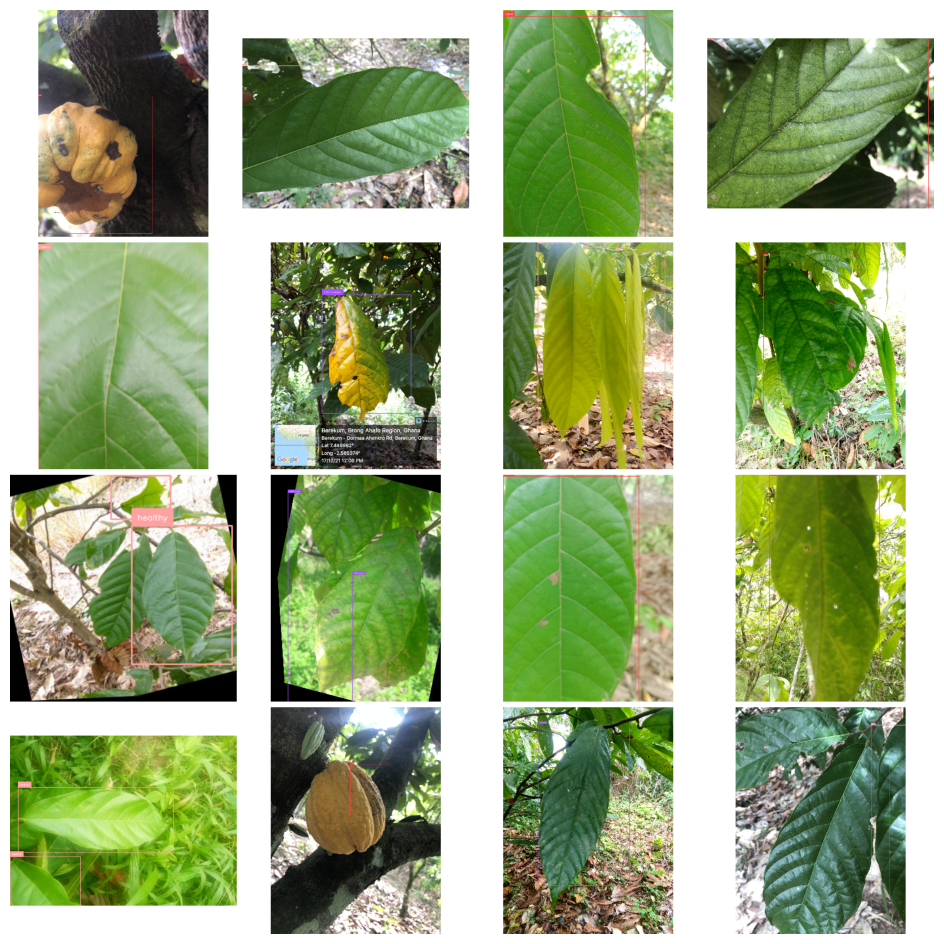

In [29]:
sv.plot_image(grid)

In [30]:
# from transformers import AutoImageProcessor

# image_processor = AutoImageProcessor.from_pretrained(
#     checkpoint,
#     do_resize=True,
#     size={"width": image_size, "height": image_size},
#     use_fast=True,
# )

from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(
    checkpoint
)

2025-05-10 20:26:39.745782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746908799.933154      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746908799.989762      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/470 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [31]:
from torch.utils.data import Dataset

In [32]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

In [33]:
pytorch_train_dataset = PyTorchDetectionDataset(train_ds, image_processor)
pytorch_val_dataset = PyTorchDetectionDataset(val_ds, image_processor)

pytorch_train_dataset[15]

{'pixel_values': tensor([[[0.1765, 0.1686, 0.1647,  ..., 0.3804, 0.4118, 0.4118],
          [0.2039, 0.1804, 0.1608,  ..., 0.3412, 0.4000, 0.4196],
          [0.2196, 0.1961, 0.1608,  ..., 0.3098, 0.3569, 0.3882],
          ...,
          [0.9961, 0.9922, 0.9804,  ..., 0.4078, 0.3882, 0.4667],
          [0.9922, 0.9804, 0.9608,  ..., 0.4000, 0.4235, 0.4588],
          [0.9647, 0.9451, 0.9412,  ..., 0.4353, 0.4431, 0.4196]],
 
         [[0.2824, 0.2745, 0.2706,  ..., 0.3882, 0.4157, 0.4196],
          [0.3098, 0.2863, 0.2667,  ..., 0.3529, 0.4078, 0.4314],
          [0.3255, 0.3020, 0.2667,  ..., 0.3294, 0.3725, 0.4078],
          ...,
          [1.0000, 0.9922, 0.9804,  ..., 0.4118, 0.3882, 0.4627],
          [0.9961, 0.9843, 0.9647,  ..., 0.4078, 0.4275, 0.4588],
          [0.9686, 0.9490, 0.9451,  ..., 0.4392, 0.4510, 0.4275]],
 
         [[0.2157, 0.2078, 0.2039,  ..., 0.3490, 0.3843, 0.3804],
          [0.2431, 0.2196, 0.2000,  ..., 0.3098, 0.3725, 0.3882],
          [0.2549, 0.235

In [34]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

In [35]:
id2label = {id: label for id, label in enumerate(train_ds.classes)}
label2id = {label: id for id, label in enumerate(train_ds.classes)}

In [36]:
label2id

{'anthracnose': 0, 'cssvd': 1, 'healthy': 2}

In [37]:
import numpy as np
from dataclasses import dataclass
from transformers.image_transforms import center_to_corners_format
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, size in zip(target_batch, image_size_batch):

                # here we have "yolo" format (x_center, y_center, width, height) in relative coordinates 0..1
                # and we need to convert it to "pascal" format (x_min, y_min, x_max, y_max) in absolute coordinates
                height, width = size
                boxes = torch.tensor(target["boxes"])
                boxes = center_to_corners_format(boxes)
                boxes = boxes * torch.tensor([[width, height, width, height]])

                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=image_processor, threshold=0.01, id2label=id2label)

In [38]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json:   0%|          | 0.00/6.90k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

Some weights of DFineForObjectDetection were not initialized from the model checkpoint at ustc-community/dfine-nano-coco and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([3]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 128]) in the checkpoint and torch.Size([3, 128]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([3]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 128]) in the checkpoint and torch.Size([3, 128]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([3]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 128]) in the checkpoint and torch.Size([3, 128]) in the model instantiated
- model.d

In [39]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="d-fine-m-cppe5-finetune-2",
    num_train_epochs=15,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=2,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    report_to= "none"   #"tensorboard",  # or "wandb"
)

In [40]:
# # import os
# # os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [41]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_train_dataset,
    eval_dataset=pytorch_val_dataset,
    processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Anthracnose,Mar 100 Anthracnose,Map Cssvd,Mar 100 Cssvd,Map Healthy,Mar 100 Healthy
1,28.475000,4.909751,0.016100,0.023300,0.016500,0.000000,0.000100,0.016600,0.290800,0.425700,0.582700,0.000000,0.043100,0.595400,0.016000,0.491300,0.017000,0.650000,0.015200,0.607000
2,24.947400,8.130060,0.019300,0.030400,0.021300,0.000000,0.000400,0.019500,0.285500,0.424500,0.578100,0.000000,0.070800,0.589900,0.012500,0.448900,0.030100,0.653700,0.015300,0.631600
3,22.413900,5.882936,0.023100,0.035700,0.026500,0.000000,0.000400,0.023400,0.232800,0.394700,0.553700,0.000000,0.070100,0.564400,0.012000,0.409000,0.045700,0.643200,0.011600,0.608800
4,21.250900,5.325417,0.022700,0.033600,0.023400,0.000000,0.000300,0.023200,0.255100,0.403400,0.561100,0.000000,0.044400,0.573400,0.005800,0.412300,0.046900,0.664000,0.015500,0.607100
5,20.978400,4.729149,0.025000,0.038400,0.027100,0.000000,0.000700,0.025500,0.246500,0.393700,0.545700,0.000000,0.063200,0.557100,0.006900,0.368200,0.047500,0.648200,0.020500,0.620800
6,20.471100,3.666243,0.028500,0.040300,0.030900,0.000000,0.001100,0.029000,0.255800,0.406700,0.558200,0.000000,0.068800,0.569400,0.006900,0.367900,0.060500,0.680500,0.018000,0.626000
7,20.167900,3.533048,0.028600,0.043600,0.030300,0.000000,0.001400,0.029100,0.255100,0.408600,0.577300,0.000000,0.083300,0.587900,0.008000,0.436800,0.058800,0.667200,0.019100,0.628100
8,19.829500,3.421290,0.027200,0.042600,0.029700,0.000000,0.007600,0.027700,0.237500,0.406300,0.568900,0.000000,0.079900,0.579200,0.007600,0.440100,0.054000,0.656900,0.020000,0.609700
9,19.806400,3.479355,0.029400,0.045100,0.033300,0.000000,0.007700,0.029900,0.278500,0.436500,0.599700,0.000000,0.056200,0.611900,0.018300,0.482700,0.047600,0.685900,0.022200,0.630500
10,19.351900,3.400810,0.021300,0.036000,0.022500,0.000000,0.000500,0.021700,0.244300,0.417800,0.575700,0.000000,0.058300,0.587200,0.011900,0.471500,0.034600,0.653100,0.017300,0.602600


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias'].


TrainOutput(global_step=36420, training_loss=21.70938540379599, metrics={'train_runtime': 10411.0738, 'train_samples_per_second': 6.996, 'train_steps_per_second': 3.498, 'total_flos': 1.997941665595392e+18, 'train_loss': 21.70938540379599, 'epoch': 15.0})

In [43]:
7*8/7

8.0

In [44]:
import supervision as sv
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

targets = []
predictions = []

for i in tqdm(range(len(val_ds))):
    path, sourece_image, annotations = val_ds[i]

    image = Image.open(path)
    inputs = image_processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = image_processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

  0%|          | 0/1684 [00:00<?, ?it/s]

In [45]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.10
map50: 0.20
map75: 0.03


In [47]:
from transformers.image_utils import load_image

In [48]:
img = load_image(f"{cocoa_dataset}/dataset/images/train/ID_hHeMGm.jpeg")

# prepare image for the model
inputs = image_processor(images=img, return_tensors="pt").to(DEVICE)

# forward pass
outputs = model(**inputs)

logits = outputs.logits
list(logits.shape)

boxes = outputs.pred_boxes
list(boxes.shape)

# convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)
result = results[0]  # first image in batch

for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

In [49]:
test_df.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath
0,ID_Genxyu.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/test/ID_Genxyu.jpg
1,ID_svY6TG.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/test/ID_svY6TG.jpg
2,ID_d0gpda.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/test/ID_d0gpda.jpg
3,ID_frWmBT.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/test/ID_frWmBT.jpg
4,ID_TaRW6o.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/test/ID_TaRW6o.jpg


In [50]:
ss_df.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_Genxyu.jpg,healthy,0.5,100,100,100,100
1,ID_svY6TG.jpg,healthy,0.5,100,100,100,100
2,ID_d0gpda.jpg,healthy,0.5,100,100,100,100
3,ID_frWmBT.jpg,healthy,0.5,100,100,100,100
4,ID_TaRW6o.jpg,healthy,0.5,100,100,100,100


In [51]:
id2label

{0: 'anthracnose', 1: 'cssvd', 2: 'healthy'}

In [52]:
import supervision as sv
from tqdm import tqdm
import pandas as pd
cols = ['Image_ID', 'class', 'confidence', 'ymin', 'xmin',
        'ymax', 'xmax']
dat = pd.DataFrame(columns=cols)


new_data = []
no_detection = 0 # Increased if model can't detect anything from the image
no_detected_images = []
for i in tqdm(test_df['Image_ID']):
  path = f"{cocoa_dataset}/dataset/images/test/{i}"
  # path, sourece_image, annotations = val_ds[i]

  img = Image.open(path)
  inputs = image_processor(img, return_tensors="pt").to(DEVICE)

  with torch.no_grad():
      outputs = model(**inputs)

  w, h = image.size
  results = image_processor.post_process_object_detection(
      outputs, target_sizes=[(h, w)], threshold=0.3)

  detections = sv.Detections.from_transformers(results[0])
  # print(type(detections.xyxy))
  if detections.xyxy.tolist():
    conf = detections.confidence
    pred_cls = detections.class_id
    boxes = detections.xyxy

    for k in range(len(boxes)):
        
        new_data.append({
          "Image_ID": i,
          "class": id2label[int(pred_cls[k])],
          "confidence": conf[k],
          "ymin": boxes[k][1],
          "xmin": boxes[k][0],
          "ymax": boxes[k][3],
          "xmax": boxes[k][2]
        })
  # Used when model can't detect anything on the current image
  else:
    
      new_data.append({
      'Image_ID': i,
      'class': 'healthy',
      'confidence': 0.849057,
      'ymin': 1084.718384,
      'xmin': 883.349060,
      'ymax': 3059.478271,
      'xmax': 1845.286011
      })
      no_detection+=1
      no_detected_images.append(i)
      


dat = pd.concat([dat, pd.DataFrame(new_data)], ignore_index=True)

100%|██████████| 1626/1626 [04:07<00:00,  6.57it/s]


In [53]:
# These are the number of images that the D-FINE couldn't detect anything on
print(no_detection)


421


In [54]:
dat.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_Genxyu.jpg,healthy,0.849057,1084.718384,883.349060,3059.478271,1845.286011
1,ID_svY6TG.jpg,healthy,0.568768,928.925781,686.139404,2816.192871,2955.065430
2,ID_svY6TG.jpg,healthy,0.559428,857.766357,692.111511,2735.761719,2978.741455
3,ID_svY6TG.jpg,healthy,0.557886,833.287109,685.330261,2743.985596,3009.470947
4,ID_svY6TG.jpg,healthy,0.493591,797.315247,690.296570,2728.875000,3019.487061


In [55]:
dat.shape

(13981, 7)

In [56]:
dat['class'].value_counts()

class
healthy        13541
cssvd            438
anthracnose        2
Name: count, dtype: int64

In [57]:
dat.to_csv('D-FINE-Kaggle_V2.csv', index=False)